# Import necessary packages

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from skimage.io import imshow
from skimage.transform import resize
# from skimage.morphology import label
# from skimage.feature import structure_tensor
from sklearn.model_selection import KFold, train_test_split
from sklearn import datasets
# from PIL import Image, ImageDraw
import cv2

import tensorflow as tf

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

In [2]:
# Test whether GPU is present and recognized

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Define custom functions

In [3]:
# Convolution block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), \
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# Create u-net model
def get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    
    # Contracting Path
    # c is output tensor of conv layers
    # p ist output tensor of max pool layers
    # u is output tensor of up-sampling (transposed) layers
    # Batchnorm standardizes/normalizes the output of each layer where applied in order to avoid huge weights using 
    # z-scores 
    
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Compute Intersection over union (IoU), a measure of labelling accuracy
# NOTE: This is sometimes also called Jaccard score
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

# Plot sample of model prediction
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 4, figsize=(30, 20))
    ax[0].imshow(X[ix, ..., 0], cmap='Greys_r')
    
    ax[0].set_title('US-image', c="white" )
    ax[0].grid(False)

    ax[1].imshow(y[ix].squeeze(), cmap='Greys_r')
    ax[1].set_title('Aponeurosis', c="white")
    ax[1].grid(False)

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap="Greys_r")
    
    ax[2].set_title('Apo-Predicted', c="white")
    ax[2].grid(False)
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=0.5, cmap="Greys_r")
    
    ax[3].set_title('Apo-Picture binary', c="white")
    ax[3].grid(False)
    
    plt.savefig(str(ix)+"Pred_area.tif")

# Save all predictions on disk 
def save_pred_area(binary_preds): 
    for i in range(len(binary_preds)): 
        fig, (ax1)= plt.subplots(1, 1, figsize = (15, 15))
        ax1.imshow(binary_preds[i], cmap="Greys_r", interpolation="bilinear")
        ax1.set_title("Predicted Area")
        plt.savefig(str(i)+"Pred_area.tif") # Saves images to directory of notebook
    

# IMAGE AUGMENTATION

## Use only when training new models and not enough data 

In [ ]:
# Input image & mask folder variables and prefix for saved augmented images
# Change before augmentation
input_img_folder = "../DeepACSA_Training_Images/apo_image_csa_RF/insert_images/"
input_mask_folder = "../DeepACSA_Training_Images/apo_masks_csa_RF/insert_masks/"
img_aug_prefix = "rectus"

# Creating image augmentation function
gen = ImageDataGenerator(featurewise_center=True,
                        featurewise_std_normalization=True,
                        rotation_range=5, 
                        width_shift_range=0.075, 
                        height_shift_range=0.075,
                        zoom_range=0.075,
                        horizontal_flip=True)

ids = os.listdir(input_mask_folder)
seed = 131313
batch_size = 1
num_aug_images = 1 # Number of images added from augmented dataset. 


for i in range(int(len(ids) + 1)):
    
    # Choose image & mask that should be augmented 
    # Directory structur: "root/some_dorectory/"
    chosen_image = ids[i] 
    image_path = input_img_folder + chosen_image 
    mask_path = input_mask_folder + chosen_image
    image = np.expand_dims(plt.imread(image_path),0) # Read and expand image dimensions
    mask = np.expand_dims(np.expand_dims(plt.imread(mask_path),0),-1)

    # Augment images 
    aug_image = gen.flow(image, batch_size=batch_size, seed=seed, save_to_dir=input_img_folder, save_prefix=img_aug_prefix+str(i), save_format="tif")
    aug_mask = gen.flow(mask, batch_size=batch_size, seed=seed, save_to_dir=input_mask_folder, save_prefix=img_aug_prefix+str(i), save_format="tif")
    seed = seed + 1 
     
    # Add images to folder
    for i in range(num_aug_images):
        next(aug_image)[0].astype(np.uint8)
        next(aug_mask)[0].astype(np.uint8)
        
   

# APONEUROSIS TRAINING

# Set image scaling parameters, determine no. of images for training

In [4]:
# Images will be re-scaled
im_width = 256
im_height = 256
border = 5

# list of all images in the path
ids = os.listdir("../DeepACSA_Training_Images/apo_image_csa_Gastro/insert_images/")
print("Total no. of aponeurosis images = ", len(ids))
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

Total no. of aponeurosis images =  233


# Load images and corresponding labels (masks)

In [5]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = cv2.imread("../DeepACSA_Training_Images/apo_image_csa_Gastro/insert_images/"+str(id_), 0)
    #print(id_)
    #print(img)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(20, 20)) #clipLimit = 2.0 for RF
    img = clahe.apply(img)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("../DeepACSA_Training_Images/apo_masks_csa_Gastro/insert_masks/"+id_, color_mode='grayscale'))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Normalise and store images
    X[n] = x_img/255.0
    y[n] = mask/255.0

<ipython-input-5-1f11347c5f5d>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/233 [00:00<?, ?it/s]

# Set up aponeurosis training

In [6]:
# Split data into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1) # i.e. 90% training / 10% test split

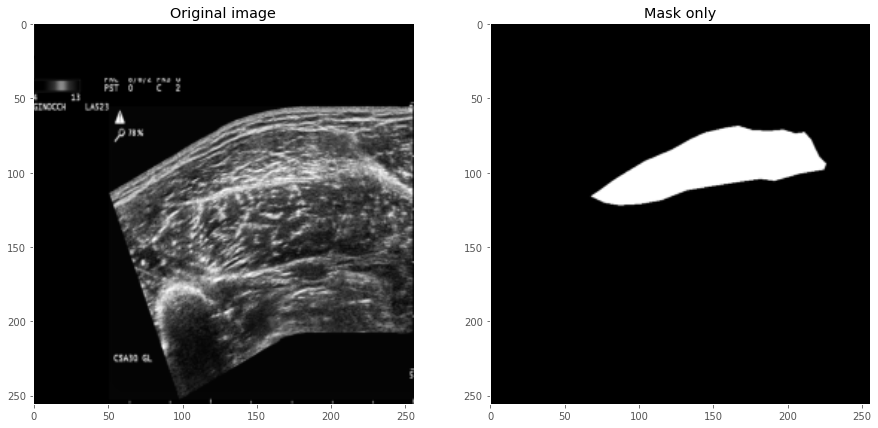

In [7]:
# Visualize a random image along with the mask (not necessary, just for checking)
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # Check whether there's at least 1 aponeurosis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))
ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if at least 1 aponeurosis is present
    #draw the aponeuroses on the original image
    #ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 0, levels = [0.5])
    ax1.set_title('Original image')
    ax1.grid(False)
    ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
    ax2.set_title('Mask only')
    ax2.grid(False)

In [8]:
# Compile the aponeurosis model
input_img = Input((im_height, im_width, 1), name='img')
model_apo = get_unet(input_img, n_filters=64, dropout=0.25, batchnorm=True) # If n_filters = 64 & Size 512x512 OOM error...
model_apo.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", IoU])

In [ ]:
# Show a summary of the model structure
model_apo.summary()

In [9]:
# Set some training parameters
callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Gastro1-256.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger('weights-Gastro1-256.csv', separator=',', append=False)
]

# Train the aponeurosis model (keep batch size small!)

In [10]:
results = model_apo.fit(X_train, y_train, batch_size=1, epochs=60,
                       callbacks=callbacks, validation_data=(X_valid, y_valid))

Epoch 1/60
209/209 [==============================] - 20s 57ms/step - loss: 0.2327 - accuracy: 0.9034 - IoU: 0.8869 - val_loss: 0.5199 - val_accuracy: 0.8437 - val_IoU: 0.8138

Epoch 00001: val_loss improved from inf to 0.51988, saving model to model-Gastro1-256.h5
Epoch 2/60
209/209 [==============================] - 11s 53ms/step - loss: 0.1093 - accuracy: 0.9415 - IoU: 0.9556 - val_loss: 0.1136 - val_accuracy: 0.9376 - val_IoU: 0.9578

Epoch 00002: val_loss improved from 0.51988 to 0.11361, saving model to model-Gastro1-256.h5
Epoch 3/60
209/209 [==============================] - 11s 53ms/step - loss: 0.0914 - accuracy: 0.9474 - IoU: 0.9643 - val_loss: 0.1143 - val_accuracy: 0.9334 - val_IoU: 0.9649

Epoch 00003: val_loss did not improve from 0.11361
Epoch 4/60
 16/209 [=>............................] - ETA: 10s - loss: 0.0677 - accuracy: 0.9594 - IoU: 0.9729

KeyboardInterrupt: 

NameError: name 'results' is not defined

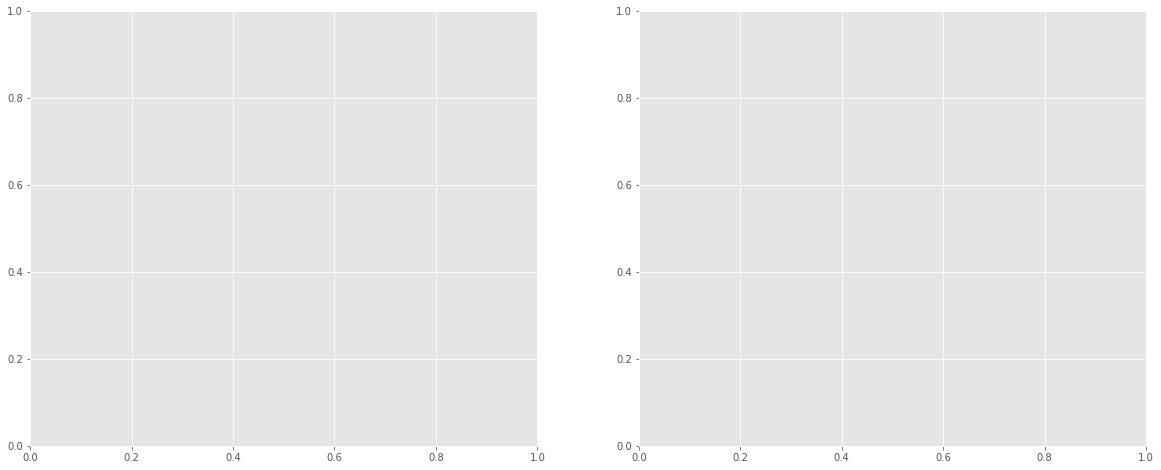

In [11]:
# Visualise the results of training
# Variables stored in results.history: val_loss, val_acc, val_IoU, loss, acc, IoU, lr
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(results.history["loss"], label="Training loss")
ax[0].plot(results.history["val_loss"], label="Validation loss")
ax[0].set_title('Learning curve')
ax[0].plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log_loss")
ax[0].legend();

ax[1].plot(results.history["val_IoU"], label="Training IoU")
ax[1].plot(results.history["IoU"], label="Validation IoU")
ax[1].set_title("IoU curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU score")
ax[1].legend()

In [ ]:
# # Evaluate on validation set (loss, acc, IoU)
model_apo.evaluate(X_valid, y_valid, verbose=2)

In [ ]:
# Predict on training and validations sets
preds_train = model_apo.predict(X_train, verbose=1)
preds_val = model_apo.predict(X_valid, verbose=1)

# Threshold predictions (only keep predictions with a minimum level of confidence)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
results.history # Show the loss values (these are saved to a .csv file using 'CSVLogger' callback defined above)